## Data quality check / cleaning / preparation 

In [33]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# CV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score,train_test_split,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, ParameterGrid
import time as time

# Models
from sklearn.linear_model import LogisticRegression
from patsy import dmatrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier

OnlineNewsPopularity = pd.read_csv("OnlineNewsPopularity.csv")

In [19]:
clean = OnlineNewsPopularity.drop(['url'], axis = 1)

### Distribution of response
*By Daniel He*

<AxesSubplot:xlabel=' shares', ylabel='Density'>

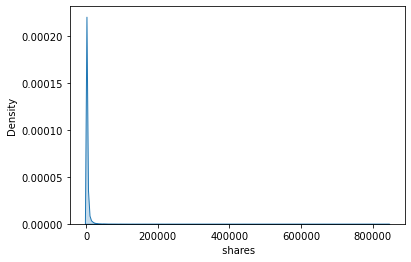

In [20]:
# Heavily skewed, will try logging the response variable
response_clean = clean[' shares']
sns.kdeplot(response_clean, fill=True, bw_method = .1)

### Data cleaning
*By Sarah Hsu*

In [21]:
data = OnlineNewsPopularity.rename(columns={'url': 'url', ' timedelta': 'timedelta', ' n_tokens_title': "n_tokens_title", ' n_tokens_content': 'n_tokens_content',
       ' n_unique_tokens': 'n_unique_tokens', ' n_non_stop_words': 'n_non_stop_words', ' n_non_stop_unique_tokens': 'n_non_stop_unique_tokens',
       ' num_hrefs': 'num_hrefs', ' num_self_hrefs': 'num_self_hrefs', ' num_imgs': 'num_imgs', ' num_videos': 'num_videos',
       ' average_token_length': 'average_token_length', ' num_keywords': 'num_keywords', ' data_channel_is_lifestyle': 'data_channel_is_lifestyle',
       ' data_channel_is_entertainment': 'data_channel_is_entertainment', ' data_channel_is_bus': 'data_channel_is_bus',
       ' data_channel_is_socmed': 'data_channel_is_socmed', ' data_channel_is_tech': 'data_channel_is_tech',
       ' data_channel_is_world': 'data_channel_is_world', ' kw_min_min': 'kw_min_min', ' kw_max_min': 'kw_max_min', ' kw_avg_min': 'kw_avg_min',
       ' kw_min_max': 'kw_min_max', ' kw_max_max': 'kw_max_max', ' kw_avg_max': 'kw_avg_max', ' kw_min_avg': 'kw_min_avg',
       ' kw_max_avg': 'kw_max_avg', ' kw_avg_avg': 'kw_avg_avg', ' self_reference_min_shares': 'self_reference_min_shares',
       ' self_reference_max_shares': 'self_reference_max_shares', ' self_reference_avg_sharess': 'self_reference_avg_sharess',
       ' weekday_is_monday': 'weekday_is_monday', ' weekday_is_tuesday': 'weekday_is_tuesday', ' weekday_is_wednesday': 'weekday_is_wednesday',
       ' weekday_is_thursday': 'weekday_is_thursday', ' weekday_is_friday': 'weekday_is_friday', ' weekday_is_saturday': 'weekday_is_saturday',
       ' weekday_is_sunday': 'weekday_is_sunday', ' is_weekend': 'is_weekend', ' LDA_00': 'LDA_00', ' LDA_01': 'LDA_01', ' LDA_02': 'LDA_02',
       ' LDA_03': 'LDA_03', ' LDA_04': 'LDA_04', ' global_subjectivity': 'global_subjectivity',
       ' global_sentiment_polarity': 'global_sentiment_polarity', ' global_rate_positive_words': 'global_rate_positive_words',
       ' global_rate_negative_words': 'global_rate_negative_words', ' rate_positive_words' : 'rate_positive_words',
       ' rate_negative_words': 'rate_negative_words', ' avg_positive_polarity': 'avg_positive_polarity',
       ' min_positive_polarity': 'min_positive_polarity', ' max_positive_polarity': 'max_positive_polarity',
       ' avg_negative_polarity': 'avg_negative_polarity', ' min_negative_polarity': 'min_negative_polarity',
       ' max_negative_polarity': 'max_negative_polarity', ' title_subjectivity': 'title_subjectivity',
       ' title_sentiment_polarity': 'title_sentiment_polarity', ' abs_title_subjectivity': 'abs_title_subjectivity',
       ' abs_title_sentiment_polarity': 'abs_title_sentiment_polarity', ' shares': 'shares'})

In [22]:
# We observed from EDA that there was this one faulty value in a 0-1 range variable, with an observation in the 700s
# n_unique_tokens is an error
data.iloc[data.n_unique_tokens.argmax()]

url                             http://mashable.com/2014/08/18/ukraine-civilia...
timedelta                                                                   142.0
n_tokens_title                                                                9.0
n_tokens_content                                                           1570.0
n_unique_tokens                                                             701.0
                                                      ...                        
title_subjectivity                                                            0.0
title_sentiment_polarity                                                      0.0
abs_title_subjectivity                                                        0.0
abs_title_sentiment_polarity                                                  0.0
shares                                                                       5900
Name: 31037, Length: 61, dtype: object

In [23]:
# Also an error
data.iloc[31037].n_non_stop_words

1042.0

In [24]:
# Also an error
data.iloc[31037].n_non_stop_unique_tokens

650.0

In [25]:
# Transforming
data.iloc[31037, data.columns.get_loc('n_unique_tokens')] = data.n_unique_tokens[31037]/data.n_tokens_content[31037]
data.iloc[31037, data.columns.get_loc('n_non_stop_words')] = data.n_non_stop_words[31037]/data.n_tokens_content[31037]
data.iloc[31037, data.columns.get_loc('n_non_stop_unique_tokens')] = data.n_non_stop_unique_tokens[31037]/data.n_tokens_content[31037]

In [26]:
# Checking that observation again, and now it is fixed
data.iloc[31037]

url                             http://mashable.com/2014/08/18/ukraine-civilia...
timedelta                                                                   142.0
n_tokens_title                                                                9.0
n_tokens_content                                                           1570.0
n_unique_tokens                                                          0.446497
                                                      ...                        
title_subjectivity                                                            0.0
title_sentiment_polarity                                                      0.0
abs_title_subjectivity                                                        0.0
abs_title_sentiment_polarity                                                  0.0
shares                                                                       5900
Name: 31037, Length: 61, dtype: object

### Data preparation
*By Daniel He and Sarah Hsu*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

#### Setting default classification threshold since it wasn't included in the original dataset

In [27]:
np.median(data.shares)

1400.0

In [47]:
data['popular'] = data.shares.apply(lambda x: 1 if x > np.median(data.shares)
                                    else 0)

In [49]:
data.drop(['timedelta'], axis = 1)

,url,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popular
0,http://mashable.com/2013/01/07/amazon-instant-...,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,0
1,http://mashable.com/2013/01/07/ap-samsung-spon...,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,0
2,http://mashable.com/2013/01/07/apple-40-billio...,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,1
3,http://mashable.com/2013/01/07/astronaut-notre...,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,0
4,http://mashable.com/2013/01/07/att-u-verse-apps/,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,1.0,...,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800,1
39640,http://mashable.com/2014/12/27/seth-rogen-jame...,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,48.0,...,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900,1
39641,http://mashable.com/2014/12/27/son-pays-off-mo...,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,1.0,...,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900,1
39642,http://mashable.com/2014/12/27/ukraine-blasts/,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,0.0,...,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100,0


In [50]:
# Standardizing the dataset with StandardScaler
from sklearn.preprocessing import StandardScaler

col_names = X_train.columns.tolist()

scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = col_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns = col_names) # Do NOT refit the scaler with the test data, just transform it.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['shares', 'url', 'popular'], axis = 1),
    data['popular'],
    test_size = 0.2,
    random_state = 42)

#### Feature selection

In [52]:
selection_1 = CatBoostClassifier(silent = True).fit(X_train, y_train)

In [53]:
feature_importances = pd.DataFrame(columns = ['Predictor', 'Importance'])
feature_importances['Predictor'] = X_train.columns
feature_importances['Importance'] = selection_1.feature_importances_
feature_importances.sort_values(by = 'Importance', ascending = False, inplace = True)

In [54]:
feature_importances

,Predictor,Importance
0,timedelta,5.743433
26,kw_avg_avg,5.198481
25,kw_max_avg,3.768439
27,self_reference_min_shares,3.684252
38,LDA_00,3.250486
23,kw_avg_max,2.903376
40,LDA_02,2.867674
3,n_unique_tokens,2.839125
39,LDA_01,2.757641
37,is_weekend,2.745106


In [55]:
feats = list(feature_importances[feature_importances.Importance >= np.quantile(feature_importances.Importance, 0.2)].Predictor)

In [56]:
data_dropped = pd.concat([data.loc[:, feats], data.popular], axis = 1)

## Exploratory data analysis
*By Daniel He*

In [57]:
cleaned = OnlineNewsPopularity.drop(['url'], axis = 1)

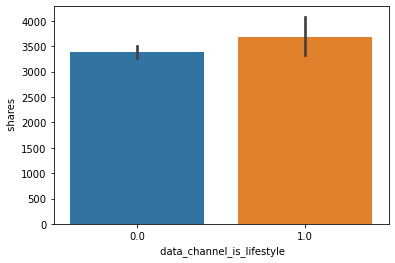

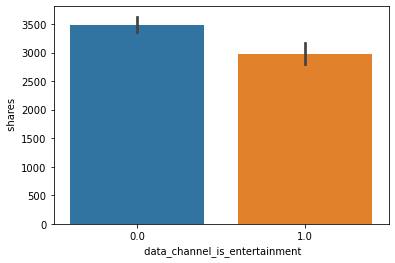

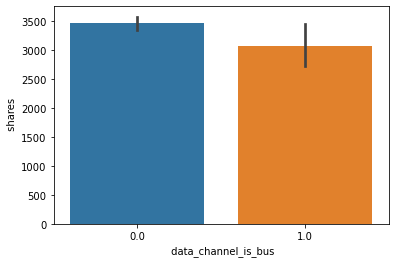

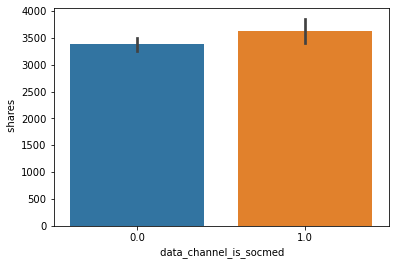

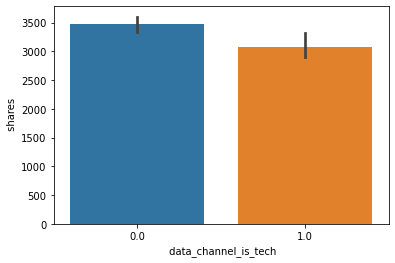

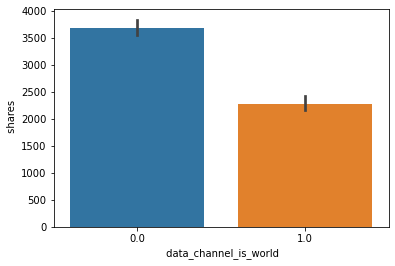

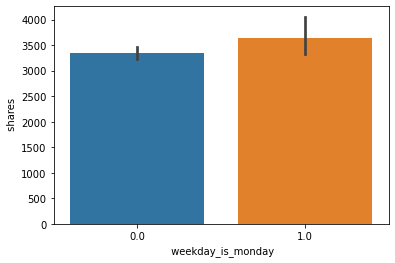

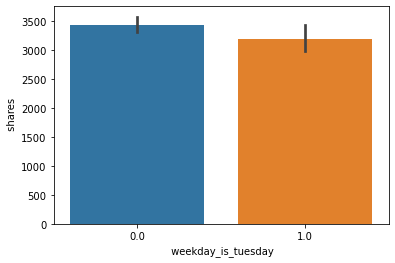

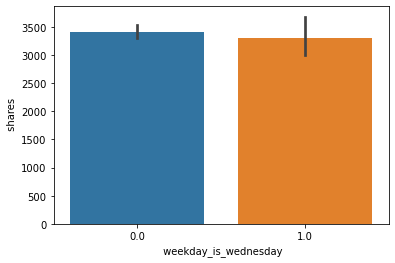

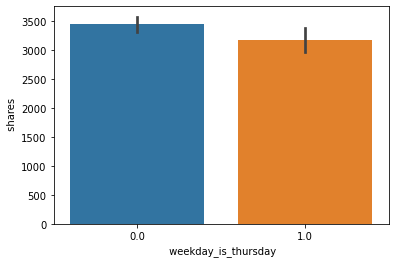

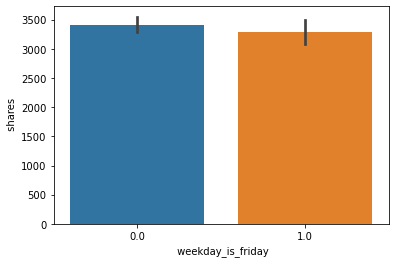

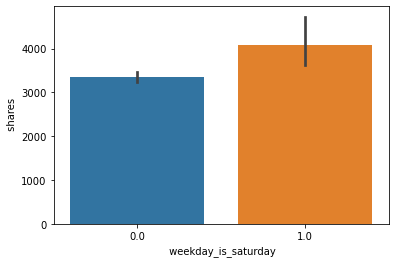

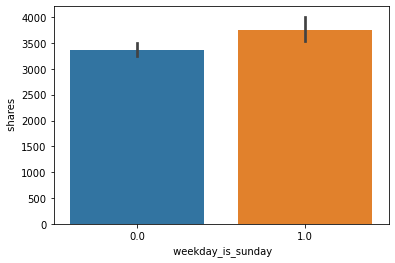

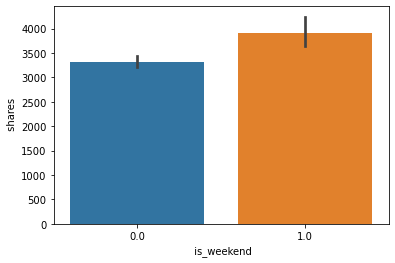

In [58]:
# Visualizing categorical variables (by Daniel He)
cleaned_cat = cleaned.loc[:, [' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' shares']]

for x in cleaned_cat.columns:
    if x != ' shares':
        sns.barplot(x= x, y = ' shares', data = cleaned_cat)
        plt.show()

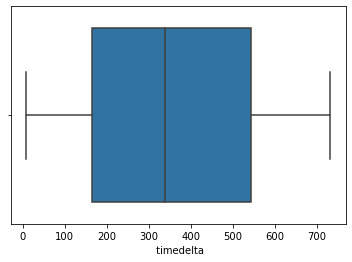

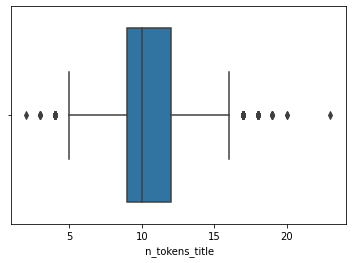

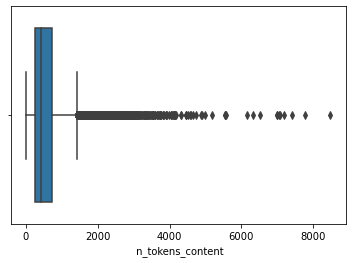

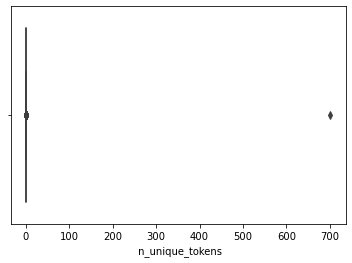

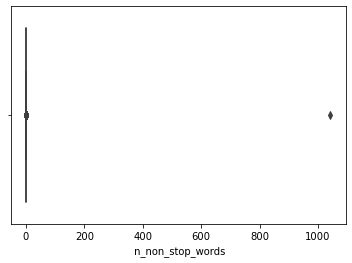

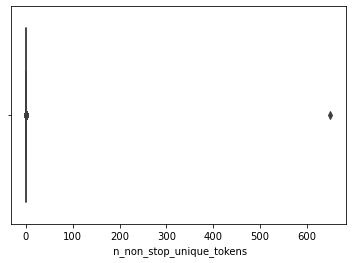

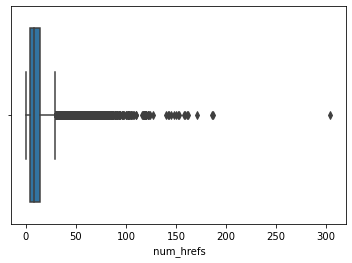

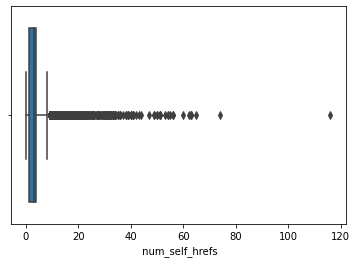

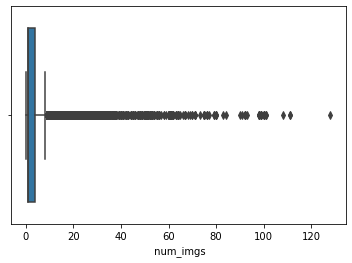

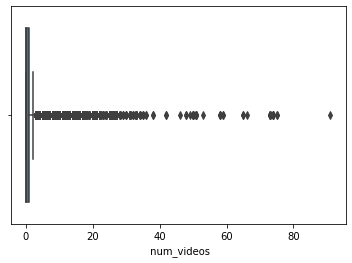

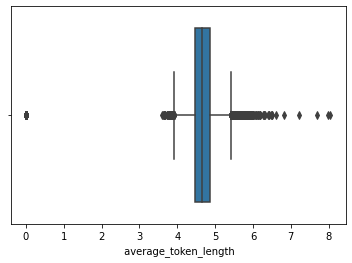

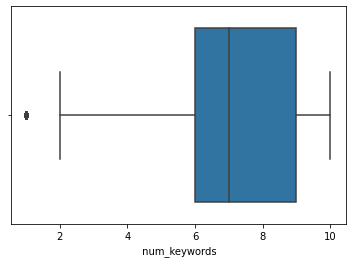

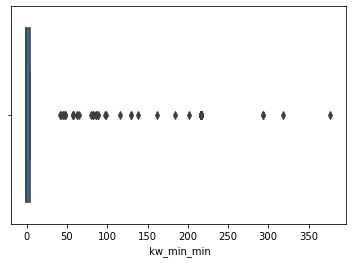

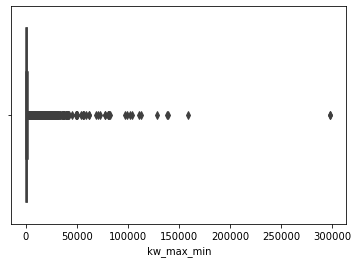

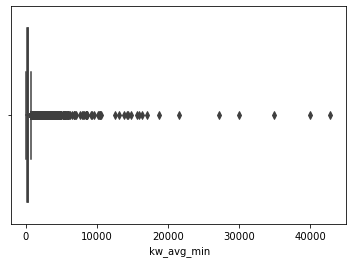

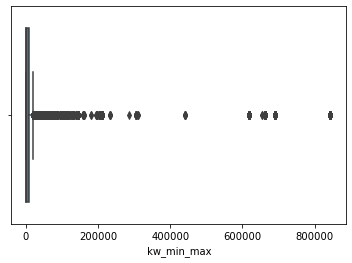

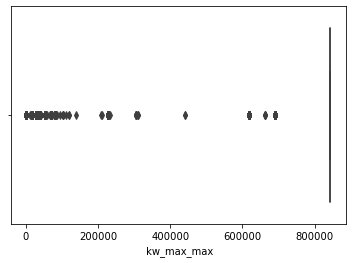

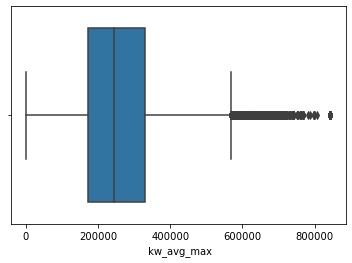

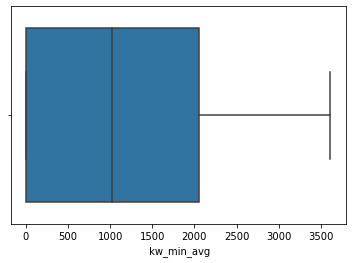

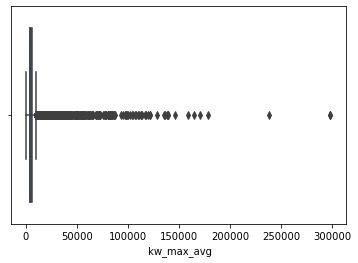

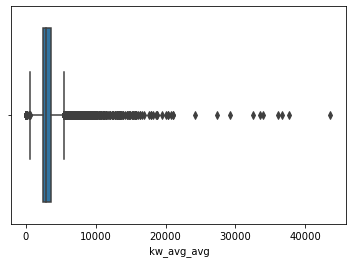

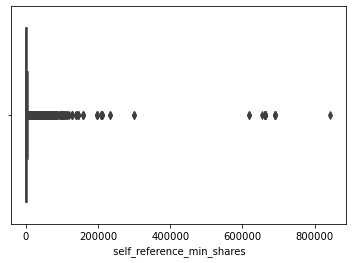

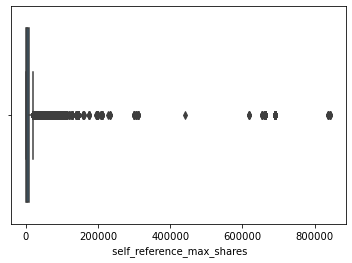

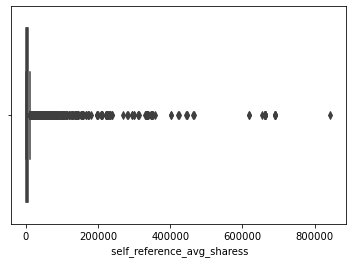

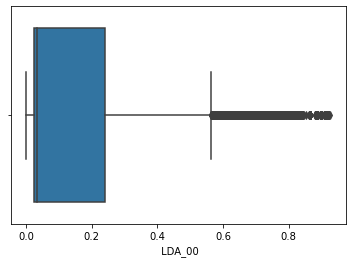

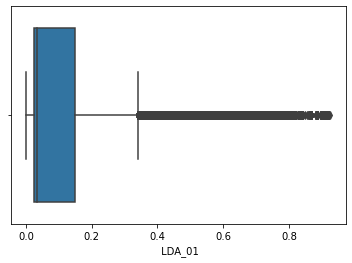

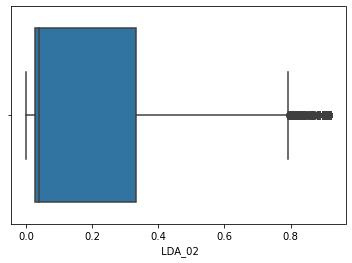

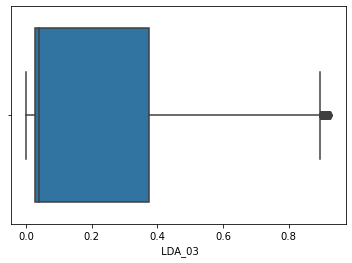

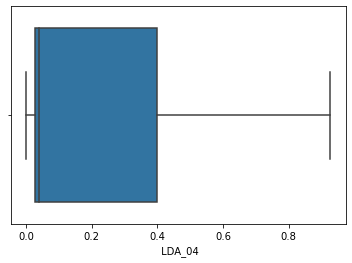

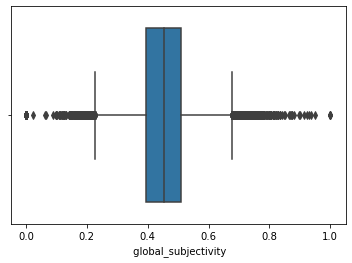

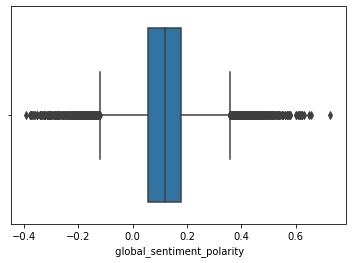

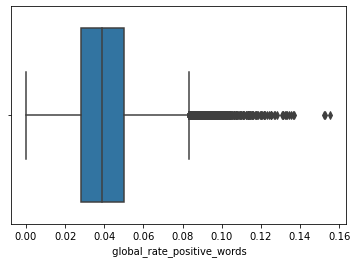

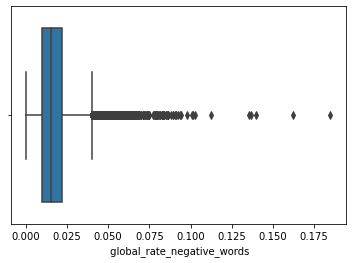

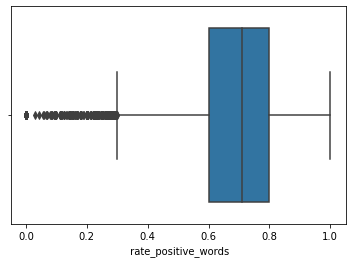

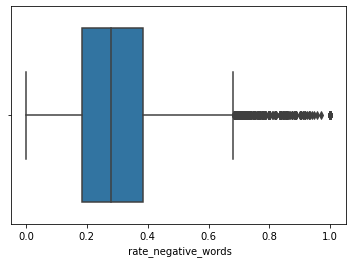

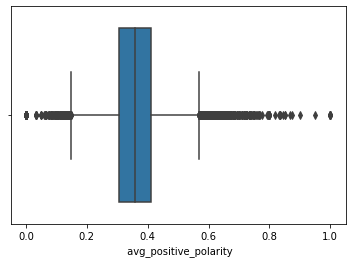

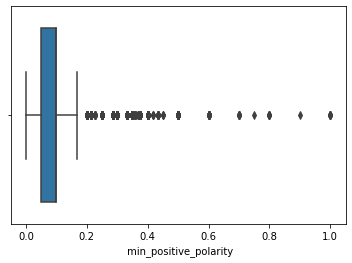

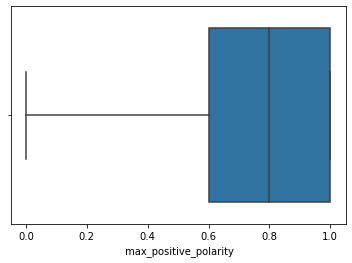

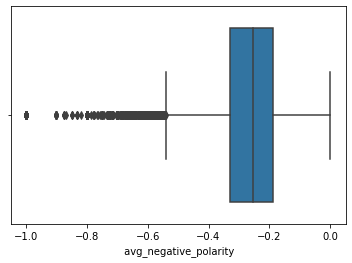

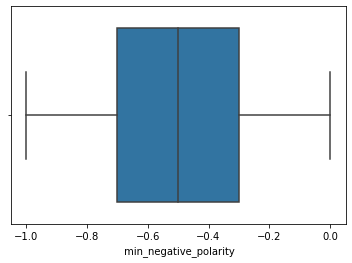

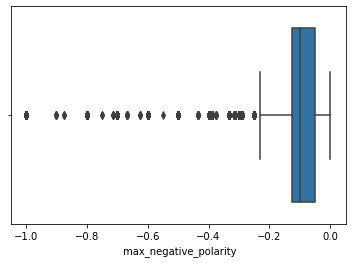

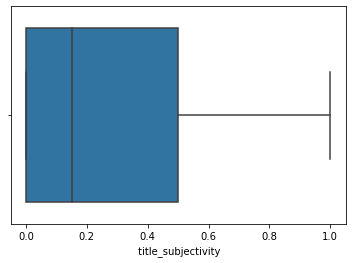

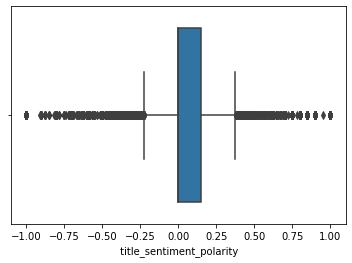

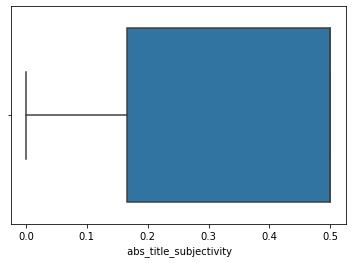

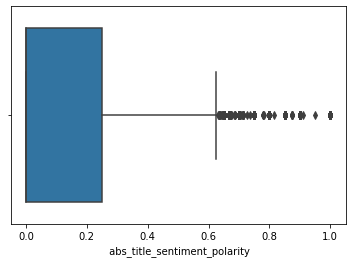

In [59]:
# Visualizing Continious variables (by Daniel He)
cleaned_con = cleaned.drop([' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' shares'], axis=1)
for x in cleaned_con:
    sns.boxplot(x= cleaned_con[x])
    plt.show()

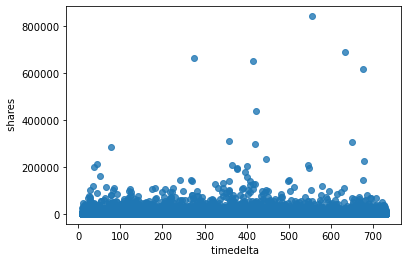

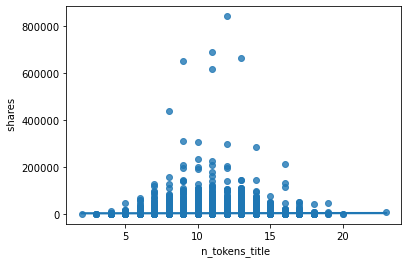

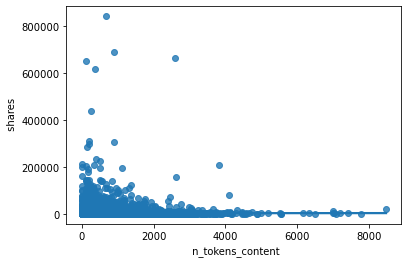

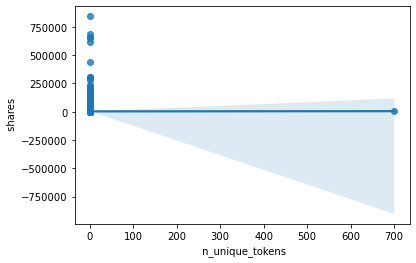

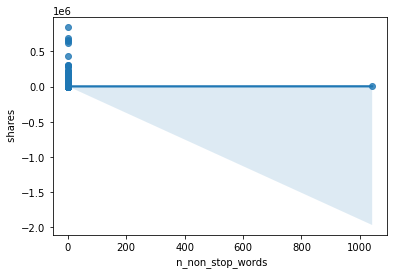

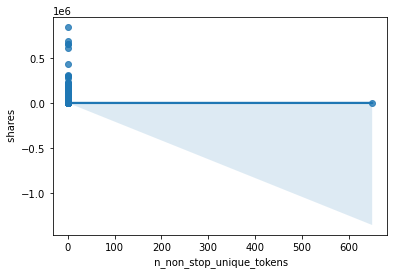

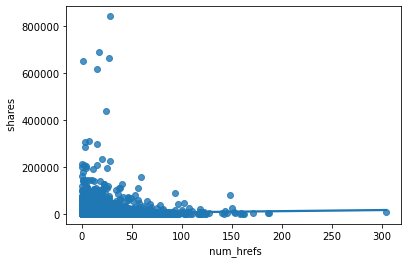

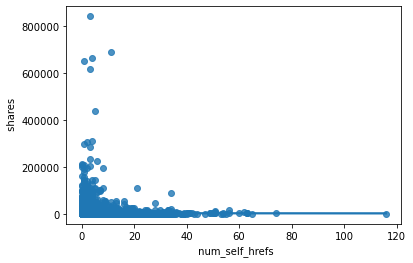

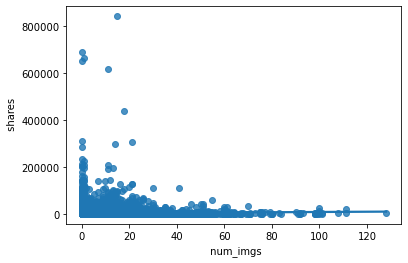

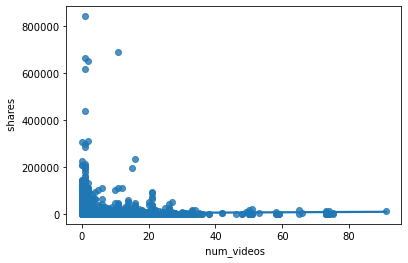

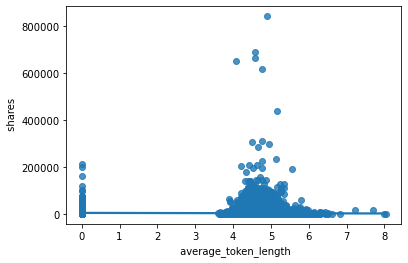

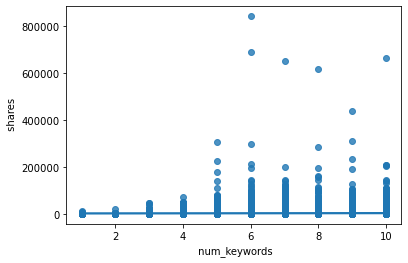

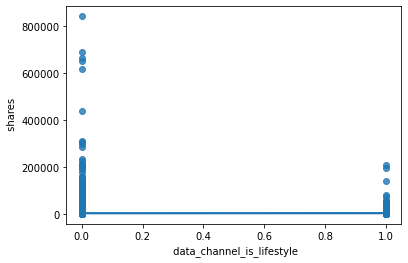

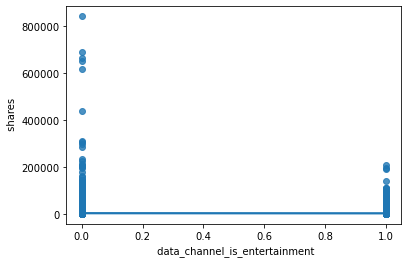

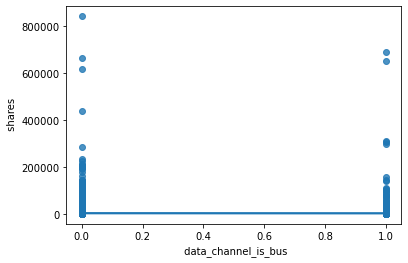

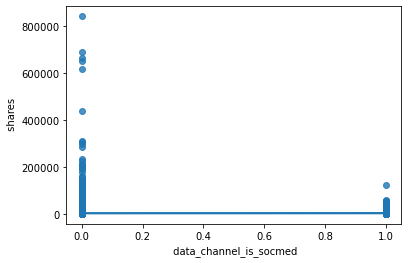

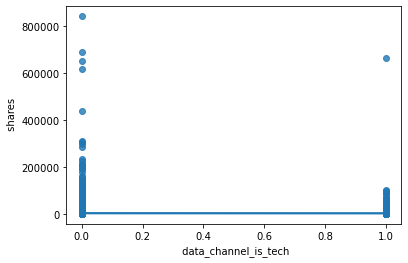

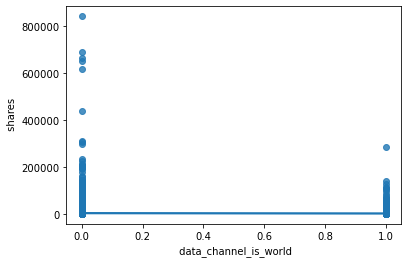

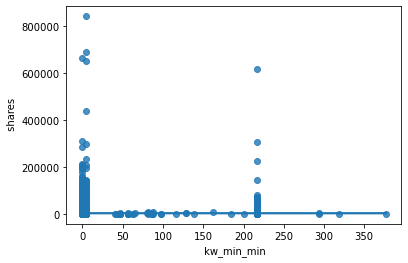

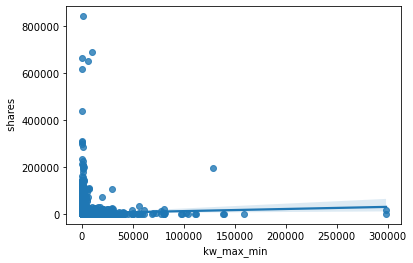

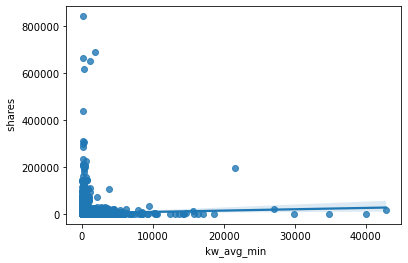

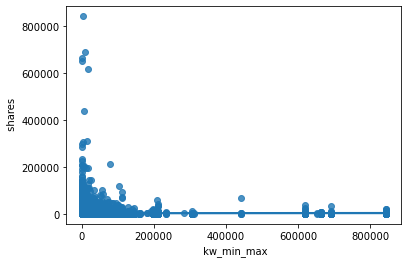

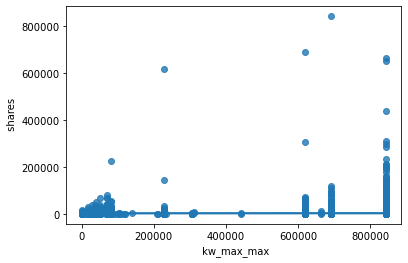

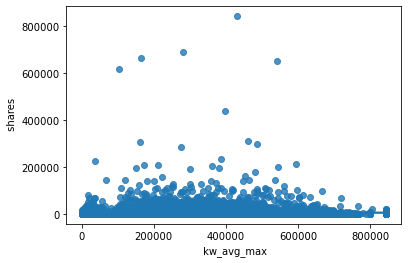

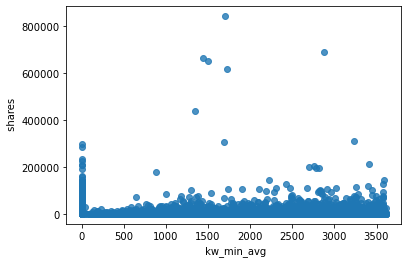

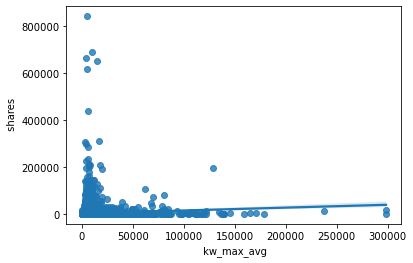

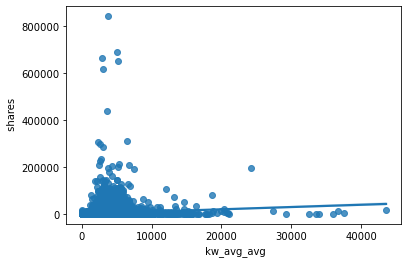

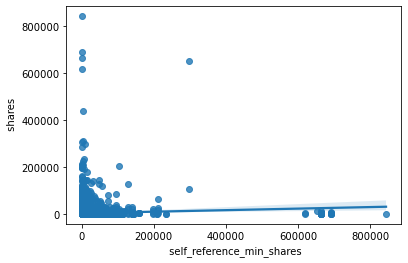

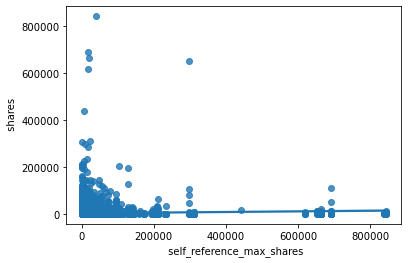

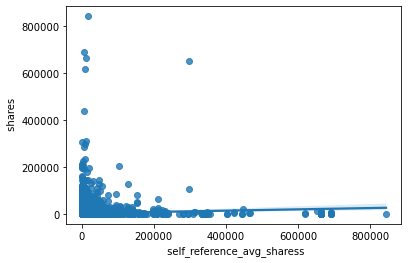

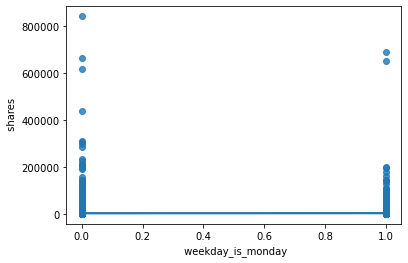

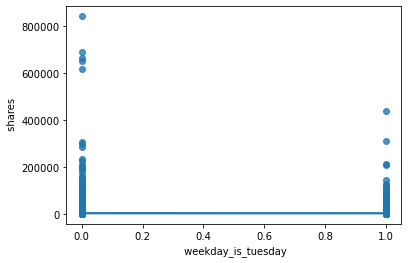

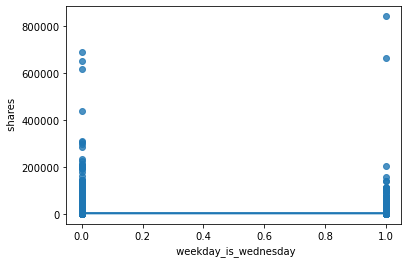

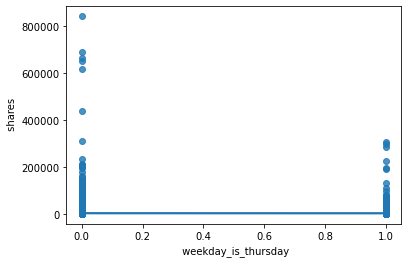

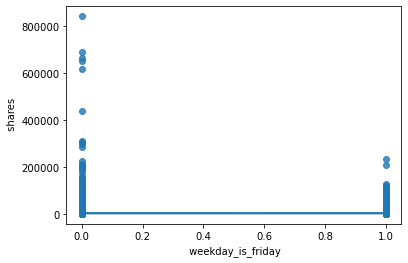

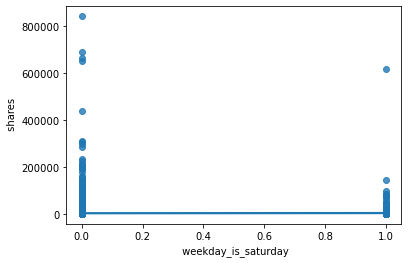

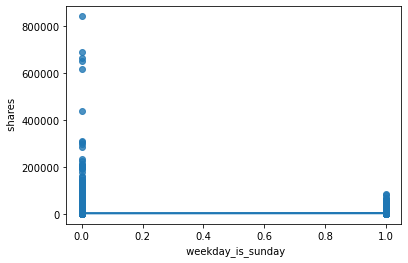

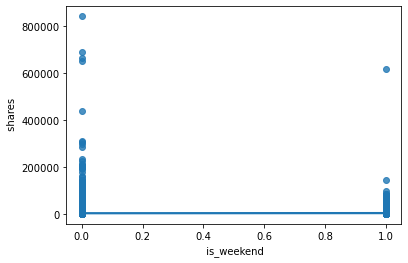

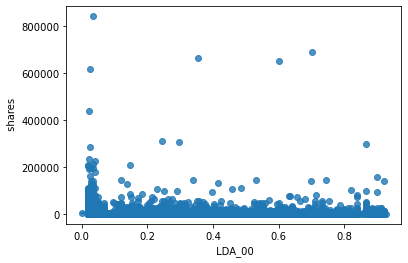

In [ ]:
# Visualizing all predictors vs. response variable of shares (by Daniel He)
for x in cleaned:
    sns.regplot(x=x, y= ' shares', data=cleaned)
    plt.show()

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### Gradient Boosting, XGBoost, LightGBM, and Catboost
*By Daniel He*

### Bagged trees, Random Forest and AdaBoost
*By Sarah Hsu*

### Ridge/Lasso
*By Gemily Wang*

### Decision Tree
*By Anika Kaura*

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models

### Innovative ensembling methods
*(Optional)*

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.